In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
import cv2, pathlib

In [ ]:
# Import Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_path = pathlib.Path('/content/drive/My Drive/data_tumor')
data_path

PosixPath('/content/drive/My Drive/data_tumor')

In [ ]:
classification_image = {
    'glioma_tumor' : list(data_path.glob('glioma_tumor/*')),
    'meningioma_tumor' : list(data_path.glob('meningioma_tumor/*')),
    'normal' : list(data_path.glob('normal/*')),
    'pituitary_tumor' : list(data_path.glob('pituitary_tumor/*'))
}

classification_code = {
    'glioma_tumor' : 0,
    'meningioma_tumor' : 1,
    'normal' : 2,
    'pituitary_tumor' : 3,
}

In [ ]:
x, y = [], []

for jenis, isi in classification_image.items():
  for data in isi:
    img = cv2.imread(str(data))
    # img_final = cv2.rescale(img, (256,256))
    x.append(img)
    y.append(classification_code[jenis])

x = np.array(x)
y = np.array(y)

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.3, random_state=42)

In [ ]:
data_generator = keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255,
    horizontal_flip= True,
    vertical_flip = True,
    zoom_range = 0.3,
    rotation_range = 40,
    fill_mode = 'nearest'
)

train_dataset = data_generator.flow(
    x_train,
    y_train
)

valid_dataset = data_generator.flow(
    x_test,
    y_test
)

Perancangan Model

In [ ]:
# Layer Input
input_layer = keras.layers.Input(shape=(256,256,3))

# Convolutional Layer
conv1 = keras.layers.Conv2D(32, (3,3), activation='relu', padding='valid')(input_layer)
max_pool1 = keras.layers.MaxPool2D(2,2)(conv1)
conv2 = keras.layers.Conv2D(64, (3,3), activation='relu', padding='valid')(max_pool1)
max_pool2 = keras.layers.MaxPool2D(2,2)(conv2)
conv3 = keras.layers.Conv2D(64, (3,3), activation='relu', padding='valid')(max_pool2)
max_pool3 = keras.layers.MaxPool2D(2,2)(conv3)
conv4 = keras.layers.Conv2D(128, (3,3), activation='relu', padding='valid')(max_pool3)
max_pool4 = keras.layers.MaxPool2D(2,2)(conv4)

# Dense dan Hidden Layer
flatten = keras.layers.Flatten()(max_pool4)
Hidden_Layer1 = keras.layers.Dense(512, activation='relu')(flatten)
Hidden_Layer2 = keras.layers.Dense(256, activation='relu')(Hidden_Layer1)
output_layer = keras.layers.Dense(4, activation='softmax')(Hidden_Layer2)

# Pembuatan Model
model = keras.models.Model(inputs=[input_layer], outputs=[output_layer])

In [ ]:
model.compile(
    optimizer = 'adam',
    loss = keras.losses.SparseCategoricalCrossentropy(),
    metrics = ['accuracy']
)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 64)        36928 

In [ ]:
model.fit(
    train_dataset,
    verbose=1,
    epochs=50,
    validation_data=valid_dataset
)

Epoch 1/50
68/68 [==============================] - 71s 854ms/step - loss: 1.3699 - accuracy: 0.2985 - val_loss: 1.3473 - val_accuracy: 0.3691
Epoch 2/50
68/68 [==============================] - 56s 835ms/step - loss: 1.2741 - accuracy: 0.3753 - val_loss: 1.1977 - val_accuracy: 0.4002
Epoch 3/50
68/68 [==============================] - 50s 737ms/step - loss: 1.1388 - accuracy: 0.4839 - val_loss: 1.0523 - val_accuracy: 0.5526
Epoch 4/50
68/68 [==============================] - 52s 770ms/step - loss: 1.0270 - accuracy: 0.5409 - val_loss: 0.9766 - val_accuracy: 0.5751
Epoch 5/50
68/68 [==============================] - 55s 812ms/step - loss: 0.9053 - accuracy: 0.6086 - val_loss: 0.9999 - val_accuracy: 0.5118
Epoch 6/50
68/68 [==============================] - 50s 731ms/step - loss: 0.8990 - accuracy: 0.6086 - val_loss: 0.8270 - val_accuracy: 0.6470
Epoch 7/50
68/68 [==============================] - 55s 816ms/step - loss: 0.8114 - accuracy: 0.6573 - val_loss: 0.9769 - val_accuracy: 0.6019

In [ ]:
y_pred = np.argmax(model.predict(x_test/255), axis=1)

from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_test, y_pred))

30/30 [==============================] - 1s 25ms/step
              precision    recall  f1-score   support

           0       0.96      0.82      0.88       287
           1       0.86      0.81      0.84       263
           2       0.91      0.97      0.94       117
           3       0.82      0.98      0.89       265

    accuracy                           0.88       932
   macro avg       0.89      0.90      0.89       932
weighted avg       0.89      0.88      0.88       932



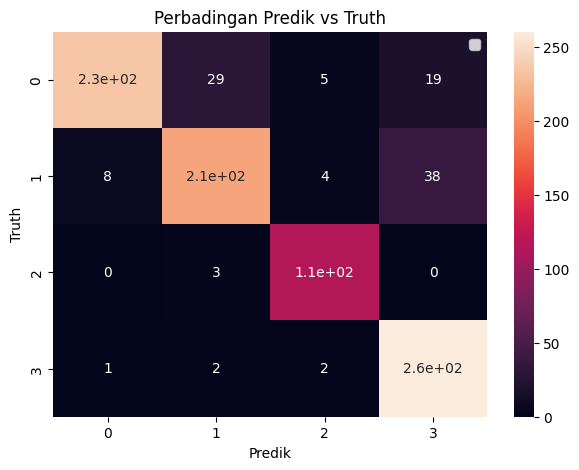

In [ ]:
import seaborn as sn

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(7,5))
sn.heatmap(cm, annot=True)
plt.xlabel('Predik')
plt.ylabel('Truth')
plt.title('Perbadingan Predik vs Truth')
plt.legend()

In [ ]:
model.save('Brain_tumor.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
pip install tensorflow-model-optimization

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.2/241.2 kB 4.8 MB/s eta 0:00:00


In [ ]:
import tensorflow_model_optimization as tfmot

quantize_train = tfmot.quantization.keras.quantize_model(model)
quantize_train.compile(
    optimizer = 'adam',
    loss = keras.losses.SparseCategoricalCrossentropy(),
    metrics = ['accuracy']
)
quantize_train.fit(
    train_dataset,
    epochs=1,
    verbose = 1,
    validation_data = valid_dataset
)

68/68 [==============================] - 58s 779ms/step - loss: 0.2267 - accuracy: 0.9195 - val_loss: 0.3764 - val_accuracy: 0.8723


In [ ]:
quantize = tf.lite.TFLiteConverter.from_keras_model(quantize_train)
quantize.optimizations = [tf.lite.Optimize.DEFAULT]
quantize_model = quantize.convert()

with open ('Brain_tumor_quantize.tflite', 'wb') as f:
  f.write(quantize_model)

/usr/local/lib/python3.10/dist-packages/tensorflow/lite/python/convert.py:887: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


In [ ]:
from google.colab import files
files.download('Brain_tumor.h5')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import files
files.download('Brain_tumor_quantize.tflite')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>